### Implementing simple Reflection Agent

In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os


In [2]:
load_dotenv()
groq_key = os.getenv("GROQ_API_KEY")

In [3]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a viral twitter influencer grading a tweet. Generate critique and recommendations for the user's tweet.
            Always provide detailed recommendations, including requests for length, virality, style, etc.
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a twitter techie influencer assistant tasked with writing excellent twitter posts.
            Generate the best twitter post possible for the user's request.
            If the user provides critique, respond with a revised version of your previous attempts.
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

llm = ChatGroq(api_key=groq_key,model="Gemma2-9b-It")

generate_chain = generation_prompt | llm

reflect_chain = reflection_prompt | llm

In [4]:
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
from chains import generate_chain, reflect_chain

In [5]:
REFLECT = "reflect"
GENERATE = "generate"

In [43]:
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({'messages': state})


# def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
#     response = reflect_chain.invoke({'messages': messages})
#     return [HumanMessage(content=response.content)]
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    response = reflect_chain.invoke({'messages': messages})
    if not response.content.strip():
        return messages  # Preserve original messages if reflection is blank
    return messages + [HumanMessage(content=response.content)]  # Append instead of replacing


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        return END
    return REFLECT

In [44]:
builder = MessageGraph()
builder.add_node(GENERATE, generation_node)
builder.add_node(REFLECT, reflection_node)
builder.set_entry_point(GENERATE)
builder.add_conditional_edges(GENERATE, should_continue)
builder.add_edge(REFLECT, GENERATE)


In [45]:
graph = builder.compile()

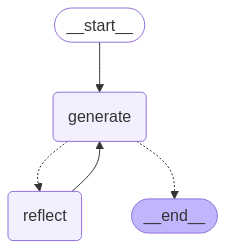

In [46]:
graph

In [47]:
inputs = HumanMessage(
    content="""
            Mondays are just mini New Years—fresh starts every week. 
            Let’s make it count! 💪 #MondayMotivation #NewWeekNewGoals
            """
            )
response = graph.invoke([inputs])

In [55]:
from pprint import pprint
pprint(response[-6].content)

('## First draft:\n'
 '\n'
 '🔥 New week, who dis?!  🔥  Mondays are the perfect time to hit refresh and '
 'crush your goals. What are you tackling first? #MondayMotivation '
 '#NewWeekNewGoals \n'
 '\n'
 '\n'
 "Let me know what you think!  I'm ready to revise if needed. 😊 \n")
